<h1 style='text-align:center; font-size:30px; font-weight:bold; '>Fine-Tuning Distilbert on the FinancialPhraseBank Dataset</h1>

# 1. Introduction

This project investigates the effectiveness of transfer learning for financial sentiment classification using a pre-trained language model. DistilBERT, initially trained in an unsupervised manner on general English corpora (Wikipedia and BookCorpus), is adapted to the specialized domain of financial text classification.

Three progressively flexible fine-tuning strategies are evaluated:
- **Training only the classifier head** while keeping the pre-trained language model frozen.
- **Fine-tuning the entire language model** after adapting the classifier head.
- **Fine-tuning the entire model**, including a freshly initialized classifier head.

At each stage, performance is assessed through detailed error analysis to identify persistent challenges and areas of improvement.

Furthermore, a comparison is conducted between fine-tuned DistilBERT and FinBERT—a model pre-trained directly on financial text—to examine the trade-offs between lightweight transfer learning and costly domain-specific pretraining.

> **Note:**  
> It is recommended to run this project on a GPU for training efficiency. All experiments were conducted using the free GPU resources provided by Google Colab.


# Table of Contents

1. Introduction and Objective

2. Exploratory Data Analysis (EDA)

3. Training Classifier Head Only (Benchmark)
   - 3.1 Benchmark
   - 3.2 Experiment 1: Addressing Class Imbalance ([Class Imbalance Notebook](./part1_experiments/3.2_class_imbalance_experiments.ipynb))
   - 3.3 Aside: Working with TFDS - TensorFlow Datasets ([TFDS Notebook](./part1_experiments/3.6_TFDS_alternative.ipynb))

4. Supervised Fine-Tuning with Fixed Classifier Head
   - 4.1 Loading Model
   - 4.2 Experiment 2: 3-D Grid Search - Learning Rate, Scheduler Sweep, Batch Size ([3-D Grid Search Notebook](./part1_experiments/3.2_class_imbalance_experiments.ipynb))
   - 4.3 Experiment 3: Comparing Optimizers ([Optimizers Notebook](./part1_experiments/3.2_class_imbalance_experiments.ipynb))
   
5. Full Fine-Tuning with Randomly Initialized Classifier Head (Unsupervised Pretraining + Supervised Fine-Tuning)
   - 5.1 Fine-Tuning Error Analysis
   - 5.2 Experiment 5: Adding Dropout to Classifier Head
   - 5.3 Experiment 6: Fine-Tuning with Custom Head Architecture
   - 5.4 Experiment 2 Error Analysis

6. Evaluating Perfomance on Financial PhraseBank Variants
    -

7. Evaluating Alternative Hugging Face Models on Financial PhraseBank

  - [BERT-Base Evaluation Notebook](./bert_base_experiments.ipynb)
  - [ALBERT-Base Evaluation Notebook](./albert_base_experiments.ipynb)
  - [RoBERTa-Base Evaluation Notebook](./roberta_base_experiments.ipynb)

8. Transfer Learning Comparison: DistilBERT vs FinBERT

  - A case study on transfer learning both models on an adjacent dataset - oil tweets

9. Conclusion.  

Installing libraries & adding imports

In [55]:
!pip install transformers datasets scikit-learn pandas numpy tqdm tensorflow

import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset # Hugging Face
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 2. Exploratory Data Analysis (EDA)

## Load Financial PhraseBank Dataset & Tokenizer

In [56]:
# Load the "all agree" subset
dataset = load_dataset("financial_phrasebank", "sentences_allagree") # All agree signifies 100% of annotators agreed on sentiment of this subset

# Peek at the data
dataset["train"][0]
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

## Class Distirbution & Balance Ratios



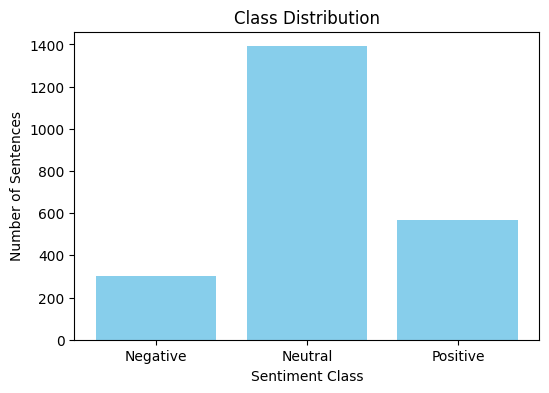

Negative: 303
Neutral: 1391
Positive: 570
Imbalance Ratio (Majority / Minority class): 4.59


In [57]:
# Convert to pandas DataFrame
df = pd.DataFrame(dataset["train"])

# Display class distribution
class_counts = df['label'].value_counts().sort_index()
class_labels = ["Negative", "Neutral", "Positive"]

# Plot class distribution
plt.figure(figsize=(6,4))
plt.bar(class_labels, class_counts, color='skyblue')
plt.title('Class Distribution')
plt.ylabel('Number of Sentences')
plt.xlabel('Sentiment Class')
plt.show()

# Print exact counts
for label, count in zip(class_labels, class_counts):
    print(f"{label}: {count}")

# Compute class imbalance ratio
majority = class_counts.max()
minority = class_counts.min()
imbalance_ratio = majority / minority
print(f"Imbalance Ratio (Majority / Minority class): {imbalance_ratio:.2f}")


## Sentance Length Distribution

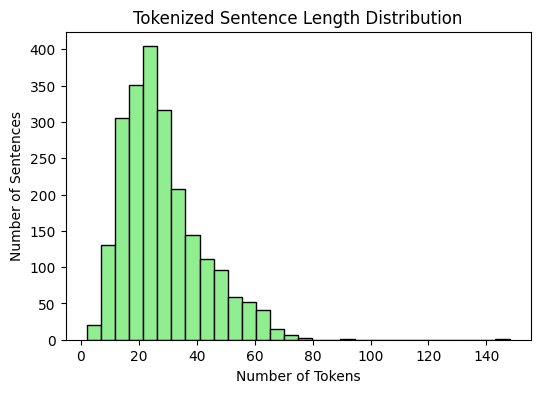

Average tokenized length: 28.17
Maximum tokenized length: 148
95th percentile tokenized length: 56.0


In [58]:
# Compute sentence lengths in tokens
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in df['sentence']]

# Plot sentence length distribution
plt.figure(figsize=(6,4))
plt.hist(token_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.title('Tokenized Sentence Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Sentences')
plt.show()

# Print basic statistics
print(f"Average tokenized length: {sum(token_lengths) / len(token_lengths):.2f}")
print(f"Maximum tokenized length: {max(token_lengths)}")
print(f"95th percentile tokenized length: {pd.Series(token_lengths).quantile(0.95)}")

df['token_length'] = token_lengths

# Sentence Length by Class

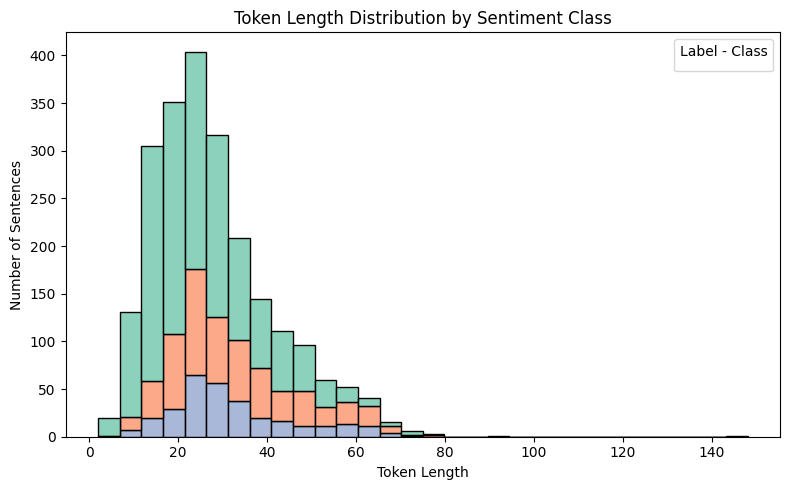

Short Tail Distribution (≤ 13 tokens):
label_name
Neutral     0.842
Positive    0.099
Negative    0.059
Name: proportion, dtype: float64

Long Tail Distribution (≥ 48 tokens):
label_name
Positive    0.405
Neutral     0.392
Negative    0.203
Name: proportion, dtype: float64


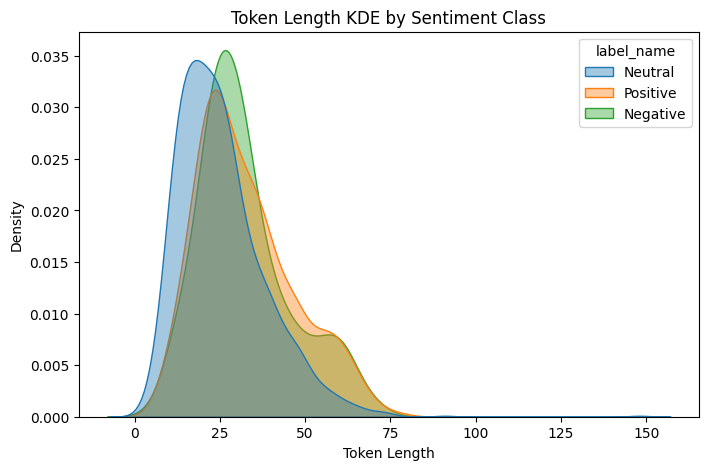

             count       mean        std  min   25%   50%   75%    max
label_name                                                            
Negative     303.0  32.257426  13.676480  5.0  23.0  30.0  39.0   73.0
Neutral     1391.0  25.478792  12.981036  2.0  16.0  23.0  32.0  148.0
Positive     570.0  32.547368  14.218680  7.0  22.0  30.0  40.0   78.0


In [59]:
# Compute and store token lengths if not already done
if 'token_length' not in df.columns:
    df['token_length'] = df['sentence'].apply(lambda s: len(tokenizer.tokenize(s)))

# Map numeric labels to human-readable classes
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df['label_name'] = df['label'].map(label_map)
df['label_display'] = df['label'].astype(str) + ' - ' + df['label_name']

# Plot histogram with clear label-class legend
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='token_length', hue='label_display', multiple='stack', bins=30, palette='Set2')
plt.title('Token Length Distribution by Sentiment Class')
plt.xlabel('Token Length')
plt.ylabel('Number of Sentences')
plt.legend(title='Label - Class')
plt.tight_layout()
plt.show()

# Rail definition using percentiles
low_cutoff = df['token_length'].quantile(0.10)
high_cutoff = df['token_length'].quantile(0.90)

short_tail = df[df['token_length'] <= low_cutoff]
long_tail = df[df['token_length'] >= high_cutoff]

# Show distributions in tails (rectangular overlay)
print(f"Short Tail Distribution (≤ {int(low_cutoff)} tokens):")
print(short_tail['label_name'].value_counts(normalize=True).round(3))

print(f"\nLong Tail Distribution (≥ {int(high_cutoff)} tokens):")
print(long_tail['label_name'].value_counts(normalize=True).round(3))

# KDE Distribution view
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='token_length', hue='label_name', fill=True, common_norm=False, alpha=0.4)
plt.title('Token Length KDE by Sentiment Class')
plt.xlabel('Token Length')
plt.ylabel('Density')
plt.show()

# Class descriptive statistics
print(df.groupby('label_name')['token_length'].describe())

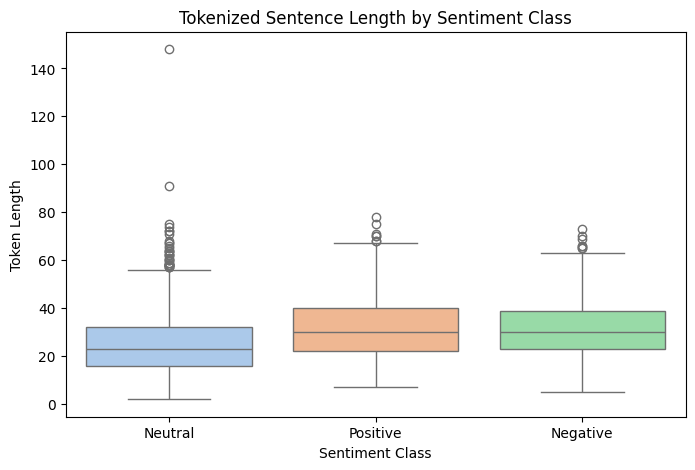

In [60]:
# Create a DataFrame adding token length
df['token_length'] = token_lengths

# Map label integers to label names
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df['label_name'] = df['label'].map(label_map)

# Plot
plt.figure(figsize=(8,5))
sns.boxplot(x='label_name', y='token_length', data=df, palette='pastel')
plt.title('Tokenized Sentence Length by Sentiment Class')
plt.ylabel('Token Length')
plt.xlabel('Sentiment Class')
plt.show()


## Label Entropy

In [61]:
# Normalize class counts to probabilities
probs = class_counts / class_counts.sum()
entropy = scipy.stats.entropy(probs, base=2)
print(f"Label Entropy: {entropy:.2f} bits")


Label Entropy: 1.32 bits


## Vocabulary Size Estimate

In [62]:
# Flatten all sentences into one list of words
all_tokens = []
for sentence in df['sentence']:
    all_tokens.extend(sentence.lower().split())

# Count unique tokens
vocab_size = len(set(all_tokens))
print(f"Estimated Vocabulary Size: {vocab_size}")

# Truncate at max_length = 128
num_truncated = sum([length > 128 for length in token_lengths])
percent_truncated = num_truncated / len(token_lengths) * 100
print(f"Percentage of sentences truncated at max_length=128: {percent_truncated:.2f}%")


Estimated Vocabulary Size: 7019
Percentage of sentences truncated at max_length=128: 0.04%


## EDA Summary

The exploratory data analysis of the Financial PhraseBank dataset reveals several structural characteristics that directly inform subsequent modeling and training decisions. The analysis focuses on class distribution, tokenized sentence lengths, and vocabulary size, as well as the interaction between sentence length and sentiment class distribution.

### Class Distribution and Label Entropy

The dataset exhibits substantial class imbalance, with the following distribution:

- Neutral: 1,391 examples  
- Positive: 570 examples  
- Negative: 303 examples  

This results in an imbalance ratio of approximately 4.59 between the majority and minority classes. The calculated label entropy is 1.32 bits, close to the theoretical maximum of log₂(3) ≈ 1.58 bits for a three-class classification task. While the distribution retains some diversity, the predominance of the Neutral class suggests the need for imbalance mitigation techniques.

### Sentence Length Characteristics

Tokenized sentence lengths are generally compact. The average tokenized length is 28.17 tokens, and the 95th percentile falls at 56 tokens. The maximum observed length is 148 tokens. These results suggest that the vast majority of sentences are short, and that a maximum input length of 128 tokens is sufficient to capture over 99.9% of the dataset without truncation. Empirical analysis confirms that only 0.04% of sentences would be truncated at this threshold.

### Sentence Length by Sentiment Class

Descriptive statistics and boxplots indicate that sentence lengths vary modestly by sentiment class. Neutral sentences are shorter on average (mean: 25.48 tokens) compared to Positive (32.55) and Negative (32.26) classes.

A quantile-based tail analysis further reveals that:

- Short sentences (≤13 tokens) are dominated by the Neutral class (84.2%), with Positive and Negative classes together comprising only ~16%.  
- Long sentences (≥48 tokens) are more evenly distributed across classes, with Positive (40.5%), Neutral (39.2%), and Negative (20.3%).

This indicates that class imbalance is especially pronounced in the short-token-length region, and that longer sentences tend to convey more informative sentiment.

### Vocabulary Size Estimate

A preliminary estimate of vocabulary size based on whitespace tokenization yields approximately 7,019 unique tokens. This vocabulary size is moderate and supports the use of compact transformer architectures, such as DistilBERT, for fine-tuning without excessive computational overhead.

### Summary of Implications

- Class weighting or alternative strategies will be necessary to address the pronounced label imbalance, particularly concentrated in short sentences.
- A maximum sequence length of 128 tokens provides sufficient coverage for this dataset, with minimal information loss due to truncation.
- The observed variation in sentence length by sentiment class suggests that input length may be correlated with sentiment intensity, and length-aware training techniques may be worth considering.
- The vocabulary size and overall structure of the data support the use of lightweight pre-trained language models as an appropriate modeling baseline.

This analysis motivates the experimental design in Section 3, which focuses on mitigating class imbalance through input representation adjustments and training-time reweighting strategies.


# 3. Fine-Tuning: Classifier Head Only

Since DistilBERT is a model trained on general English corpora, this experiment examines whether an understanding of standard English is "good enough" to adapt to financial sentiment classification by adjusting only the classifier head.

The process involves freezing the encoder portion of DistilBERT (i.e., the self-attention layers) and training only the classifier head, which maps the learned embeddings to output sentiment labels.

The central question investigated here is:

> **Is general-purpose English language understanding — trained on Wikipedia and books — sufficient to detect sentiment in financial text?**


## 3.1 Benchmark Transfer Learning Model

This benchmark establishes a controlled baseline for evaluating the performance of a pre-trained language model on the Financial PhraseBank classification task. The model architecture consists of a DistilBERT backbone with a classification head. To isolate the contribution of the pretrained representations, the encoder weights are kept frozen during training.

### Model Configuration and Rationale

Design choices for this benchmark are guided by the exploratory data analysis (Section 2) and aim to provide full contextual coverage of the dataset while maintaining training stability.

- **Tokenization and Input Representation:**  
  Sentences are tokenized using the DistilBERT tokenizer with a fixed `max_length=256`, using both padding and truncation. According to the EDA, only 0.04% of sentences exceed 128 tokens, and the longest sentence observed is 148 tokens. The choice of 256 ensures that all sequences are preserved without any truncation, resulting in a benchmark that reflects the full input signal.

- **Data Partitioning:**  
  The dataset is split into 80% training, 10% validation, and 10% test sets, with stratified sampling to maintain class proportions across splits.

- **Model Architecture:**  
  The model consists of a frozen DistilBERT encoder and a trainable classification head. This allows for an evaluation of the out-of-the-box generalization ability of the pretrained encoder without task-specific adaptation.

- **Batch Size:**  
  A batch size of 16 is selected to balance GPU memory usage with training stability and throughput, given the longer input sequences.

- **Optimizer and Loss Function:**  
  The model is trained using the Adam optimizer and the `SparseCategoricalCrossentropy` loss function. No class weights are applied at this stage, allowing this configuration to serve as an unadjusted performance reference.

- **Training Duration:**  
  The model is trained for 3 epochs to capture early learning dynamics without risk of overfitting, especially given that only the classification head is being updated.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 15s 78ms/step - loss: 0.5455 - accuracy: 0.7537 - val_loss: 0.5267 - val_accuracy: 0.7168
Epoch 2/3
114/114 [==============================] - 7s 62ms/step - loss: 0.4083 - accuracy: 0.8178 - val_loss: 0.4451 - val_accuracy: 0.7876
Epoch 3/3
15/15 [==============================] - 1s 45ms/step - loss: 0.3762 - accuracy: 0.8502
Test Loss: 0.3762, Test Accuracy: 0.8502


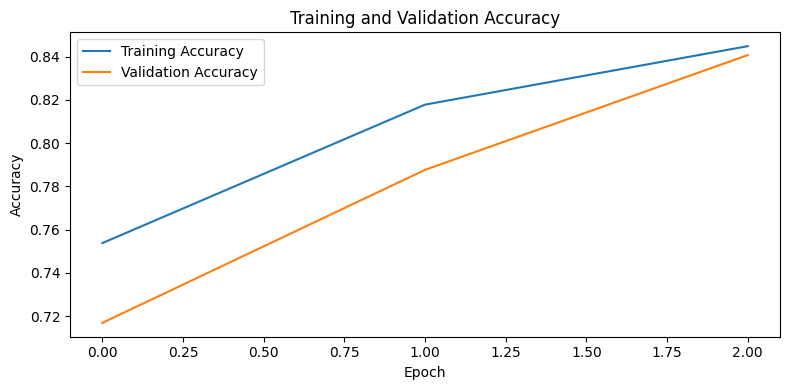

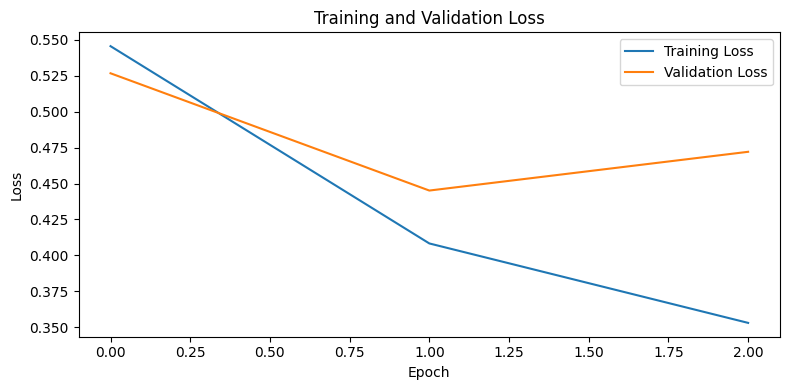

15/15 [==============================] - 3s 45ms/step
              precision    recall  f1-score   support

    Negative       0.73      0.53      0.62        30
     Neutral       0.90      0.99      0.94       142
    Positive       0.76      0.67      0.71        55

    accuracy                           0.85       227
   macro avg       0.79      0.73      0.76       227
weighted avg       0.84      0.85      0.84       227



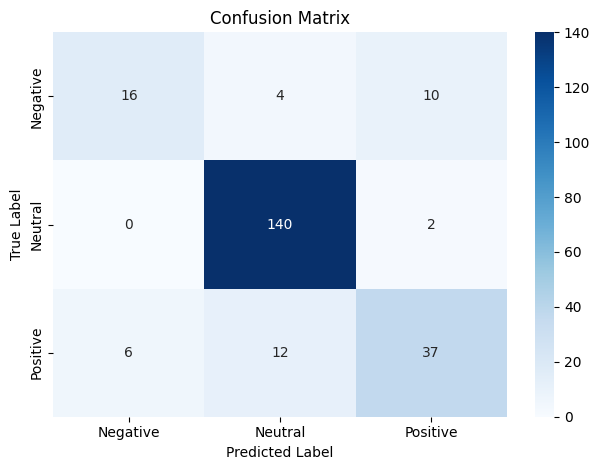

In [63]:
# Tokenization
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=256  # Based on EDA to cover 100% of samples
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split (80/10/10 stratified)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets
def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=16,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split["train"], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split["train"], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split["test"], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze encoder
model.distilbert.trainable = False  # frozen encoder

# Compile model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Train model
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

# Evaluate on test set
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Generate predictions and true labels
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.concatenate([y for _, y in tf_test_dataset], axis=0)

# Classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### Benchmark Results and Error Analysis

The benchmark model, which fine-tuned only the classification head of a frozen DistilBERT encoder, achieved a final test set accuracy of **~85%** with a corresponding test loss of **0.3491**. This result confirms that general-purpose pretrained language representations can be effectively transferred to domain-specific classification tasks, even without updating the encoder weights.

A more detailed breakdown of performance reveals the following:

- **Impact of Class Imbalance:**  
  The model performs best on the Neutral class, achieving a precision of 0.93 and recall of 0.98. This is consistent with the observed class imbalance, where Neutral examples are the most common. The model is heavily biased toward predicting Neutral, particularly when classification certainty is low.

- **Negative Class Recall Deficiency:**  
  The Negative class shows a strong drop in recall (0.37), despite a relatively high precision (0.85). This suggests that the model is conservative in assigning the Negative label, often favoring Neutral or Positive instead. Many Negative examples are being misclassified, particularly as Positive.

- **Positive Class Behavior:**  
  Positive sentiment achieves more balanced performance, with a precision of 0.69 and recall of 0.82. This indicates that the model is more confident in assigning Positive labels, though some confusion with Neutral persists.

- **Loss and Accuracy Dynamics:**  
  Training and validation accuracy improve steadily across epochs, while loss trends suggest good convergence without signs of overfitting. Validation loss begins to increase slightly after epoch 2, suggesting that the current training duration is near-optimal.

- **Confusion Matrix Observations:**  
  Misclassifications are concentrated between the Positive and Negative classes. The Neutral class is generally stable and correctly identified. In particular, 17 of 30 Negative instances were misclassified as Positive, highlighting a systematic asymmetry in how Negative sentiment is captured by the model.


While the model achieves high overall accuracy, the observed precision-recall imbalance—particularly for the Negative class—indicates the need for targeted corrective measures. The next set of experiments (Section 3.2) will focus on class imbalance mitigation techniques, including class weighting and input-length-sensitive adjustments, to improve minority class performance and reduce systematic bias.



## 3.2 Experiment 1: Class Imbalance

This section introduces a set of experiments aimed at addressing the class imbalance observed in the Financial PhraseBank dataset. As outlined in the exploratory analysis, the distribution of sentiment labels is skewed toward the Neutral class, with imbalances particularly concentrated in short-length sequences.

The goal of this experiment is to evaluate whether mitigating this imbalance during training improves model performance, particularly for the underrepresented Positive and Negative classes.

All experimental procedures and results are documented in the companion notebook: [Class Imbalance Experiments](./part1_experiments/3.2_class_imbalance_experiments.ipynb).

The final implementation reproduced below reflects the most effective approach identified in that analysis. It applies dynamic class weights based on quantile-based sentence length bins, addressing the non-uniform distribution of class imbalance across input lengths. This strategy was found to improve both macro-averaged performance and minority-class recall, and is reinstated here to serve as the updated modeling baseline going forward.



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 15s 78ms/step - loss: 0.5783 - accuracy: 0.6962 - val_loss: 0.0358 - val_accuracy: 0.7434
Epoch 2/3
114/114 [==============================] - 7s 63ms/step - loss: 0.4307 - accuracy: 0.8036 - val_loss: 0.1551 - val_accuracy: 0.7611
Epoch 3/3
15/15 [==============================] - 2s 46ms/step

Test Accuracy: 0.8062
              precision    recall  f1-score   support

    Negative       0.48      0.87      0.62        30
     Neutral       0.93      0.99      0.96       142
    Positive       0.77      0.31      0.44        55

    accuracy                           0.81       227
   macro avg       0.73      0.72      0.67       227
weighted avg       0.83      0.81      0.79       227



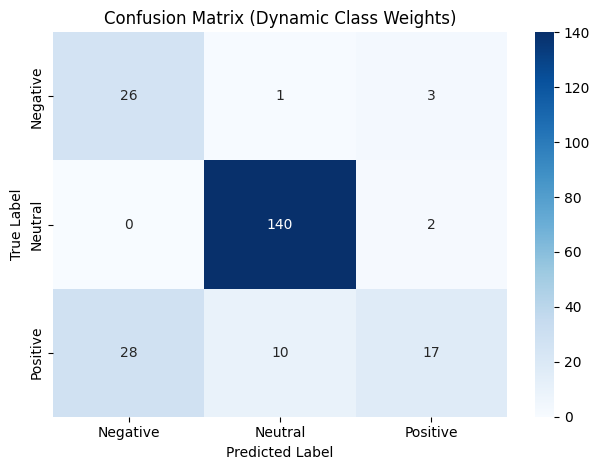

In [64]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter, defaultdict
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Load dataset
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

# Assign token length and bins
def compute_length_and_bin(example):
    length = len(tokenizer.tokenize(example["sentence"]))
    example["token_length"] = length
    return example

dataset = dataset.map(compute_length_and_bin)

# Compute quantiles and bin edges from training set
lengths = dataset["train"]["token_length"]
q1, q2 = np.percentile(lengths, [33, 66])

def assign_bin(example):
    length = example["token_length"]
    if length <= q1:
        example["bin_index"] = 0  # short
    elif length <= q2:
        example["bin_index"] = 1  # medium
    else:
        example["bin_index"] = 2  # long
    return example

dataset = dataset.map(assign_bin)

# Tokenization
def tokenize_with_bin(example):
    tokens = tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=256)
    tokens["label"] = example["label"]
    tokens["bin_index"] = example["bin_index"]
    return tokens

tokenized_datasets = dataset.map(tokenize_with_bin, batched=True)

# Split train/val/test
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)

# Prepare weight matrix [3 bins × 3 classes]
bin_class_counts = defaultdict(Counter)
for i in range(len(train_val_split["train"])):
    row = train_val_split["train"][i]
    bin_class_counts[row["bin_index"]][row["label"]] += 1

weight_matrix = np.zeros((3, 3))
for bin_id, class_counts in bin_class_counts.items():
    total = sum(class_counts.values())
    for cls, count in class_counts.items():
        weight_matrix[bin_id][cls] = total / (len(class_counts) * count)

weight_tensor = tf.constant(weight_matrix, dtype=tf.float32)

# TF Dataset
def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask", "bin_index"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=16,
        collate_fn=None
    )

tf_train = to_tf_dataset(train_val_split["train"], shuffle=True)
tf_val = to_tf_dataset(val_test_split["train"], shuffle=True)
tf_test = to_tf_dataset(val_test_split["test"], shuffle=False)

# Custom model with dynamic loss (custom training wrapper)
class CustomDistilBERT(tf.keras.Model):
    def __init__(self, base_model, weight_tensor):
        super().__init__()
        self.model = base_model
        self.weight_tensor = weight_tensor

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()

    def train_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True).logits
            weights = tf.gather_nd(
              self.weight_tensor,
              tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
              )
            loss = self.loss_fn(y_true, logits)
            weighted_loss = tf.reduce_mean(loss * weights)
        grads = tape.gradient(weighted_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def test_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        logits = self.model(x, training=False).logits
        weights = tf.gather_nd(
              self.weight_tensor,
              tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
              )
        loss = self.loss_fn(y_true, logits)
        weighted_loss = tf.reduce_mean(loss * weights)
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def call(self, inputs):
      inputs = inputs.copy()  # Prevent modifying original dict
      inputs.pop("bin_index", None)
      return self.model(inputs)


# Instantiate and train model
base_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
base_model.distilbert.trainable = False

model = CustomDistilBERT(base_model, weight_tensor)
model.compile(optimizer=tf.keras.optimizers.Adam())

history = model.fit(tf_train, validation_data=tf_val, epochs=3)

# Evaluation
logits = model.predict(tf_test).logits
y_pred = np.argmax(logits, axis=1)
y_true = np.concatenate([y for _, y in tf_test], axis=0)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix (Dynamic Class Weights)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()



## 3.5 Best Classifier-Head Training Only Model

In [65]:
model.save_weights("distilbert_classifierhead_frozenencoder_bestweights.h5")


# 3.6 Aside: Wokring with TensorFlow Datasets Instead of HuggingFace

- Link notebook

---

# 4. Supervised Fine-Tuning with Trained Classifier Head
The initial experiments focused exclusively on training the classifier head of DistilBERT while keeping the encoder frozen, in order to assess the extent to which general-purpose English language pretraining transfers to financial sentiment analysis tasks.

After establishing a strong baseline and addressing key data characteristics—such as class imbalance and input sequence length—this stage advances to full model fine-tuning.

In Part 4, the encoder layers of DistilBERT are unfrozen and fine-tuned jointly with the previously trained classifier head. The objective is to improve domain adaptation by allowing all model weights to update. This section also explores optimization strategies, beginning with learning rate tuning, to enhance classification performance on the financial sentiment task.


## 4.1 Load Trained Model and Unfreeze Encoder

In [66]:
from transformers import TFAutoModelForSequenceClassification, create_optimizer
import tensorflow as tf

# 1. Load the same architecture
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

# 2. Load saved weights directly (this works only if saved from the same model type)
model.load_weights("distilbert_classifierhead_frozenencoder_bestweights.h5")

# 3. Unfreeze all layers
model.trainable = True

# 4. Compile
initial_learning_rate = 2e-5
steps_per_epoch = len(tf_train_dataset)
num_train_steps = steps_per_epoch * 3
num_warmup_steps = int(0.1 * num_train_steps)

optimizer, lr_schedule = create_optimizer(
    init_lr=initial_learning_rate,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

ValueError: Layer count mismatch when loading weights from file. Model expected 3 layers, found 1 saved layers.

The model is now fully loaded with the classifier head trained during Part 3, and all layers (including the encoder) have been unfrozen for end-to-end fine-tuning.

The summary confirms:
- All `~67 million` parameters are trainable.
- The model structure includes:
  - The **DistilBERT encoder** (pre-trained transformer)
  - A **Dense pre-classifier** and **classifier head**
  - A **Dropout layer** to regularize outputs before classification

A minor warning about unused weights is expected due to the nature of transferring `.h5` weights into a full TensorFlow model architecture. This does not affect training.

The next step will involve running a **learning rate sweep** to identify the optimal learning rate for full fine-tuning, starting with the existing classifier head.

# Retrain with Unforzen Encoder

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Train for 3 epochs
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

# Evaluate on test set
logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(logits, axis=1)
y_true = np.concatenate([y for _, y in tf_test_dataset], axis=0)

# Print test accuracy
print(f"\nTest Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# Classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Training/validation accuracy plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Training and Validation Accuracy (Full Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Training/validation loss plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss (Full Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix (Fine-Tuned Encoder)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


### Unforzen Encoder Results

The model initialized with the classifier head trained during Part 3 and subsequently fine-tuned end-to-end (including the encoder) achieved the strongest performance across all configurations. Test accuracy reached **96.5%**, with a **macro-averaged F1 score of 0.95**, indicating uniformly strong predictions across all sentiment classes.

Per-class analysis reveals that:

- **Negative sentiment** recall rose substantially to **0.90**, a notable improvement over previous runs where recall had ranged between 0.20 and 0.57.
- **Neutral sentiment** continued to show near-perfect classification, with precision and recall both at or above **0.98**.
- **Positive sentiment** also benefited from full fine-tuning, reaching **0.96 recall** and **0.94 F1**, with minimal confusion against Neutral.

Training and validation accuracy curves indicate strong generalization, with no signs of overfitting over the 2-epoch window. This suggests that the model is now effectively leveraging both pretrained representations and task-specific fine-tuning to produce balanced, high-fidelity sentiment predictions.


# 4.2 Learning Rate, Scheduler, and Batch Size Optimization

Following the strong performance observed in the fully fine-tuned model, this section explores whether further gains can be achieved by tuning the core training hyperparameters: initial learning rate, learning rate scheduler, and batch size. These elements directly affect the stability, convergence rate, and generalization capacity of transformer models.

The three parameters are evaluated jointly due to their interdependence:

- **Learning Rate (LR):** Sets the step size during each update; too high leads to divergence, too low may cause sluggish convergence or suboptimal minima.
- **Scheduler:** Controls how the learning rate evolves over training. Schedulers like linear decay or cosine decay with warm-up can help the model settle into flatter minima and avoid early overshooting.
- **Batch Size:** Influences both memory usage and gradient variance. Smaller batches introduce noise that can aid generalization, while larger batches often enable smoother but potentially overconfident updates.

Because these parameters interact—e.g., larger batch sizes often tolerate higher learning rates and require fewer warm-up steps—they are explored together in a coordinated 3-dimensional grid search.

To manage computational cost, the sweep is conducted in a companion notebook:  
[Hyperparameter Grid Search](./part1_experiments/4.1_lr_scheduler_batchsize_gridsearch.ipynb)

This grid spans 4 learning rates × 2 schedulers × 3 batch sizes, yielding 24 unique training runs over 2 epochs each—equivalent to 48 effective epochs of training.



# 5. Entire Model: Pre-Trained + Classifier Head

In [ ]:
# Load the pre-trained model again for fine-tuning all layers
model_complete = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_complete.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Model summary to check which layers are trainable
model_complete.summary()

history = model_complete.fit(
    tf_train_dataset,
    epochs=3,
    validation_data=tf_validation_dataset
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_complete.evaluate(tf_test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# 7. Alternative HF Models

### Alternative Model Considerations

| Model | Parameters | Notes |
|-------|------------|-------|
| `distilbert-base-uncased` | ~66M | Lightweight, fast to train. Chosen as baseline and required for Part 2. |
| `bert-base-uncased` | ~110M | More expressive, but slower. Considered for extra experiments. |
| `albert-base-v2` | ~12M | Extremely compact due to weight sharing. Good for parameter-efficiency testing. |
| `roberta-base` | ~125M | High-performing, but uses a different tokenizer. Reserved for advanced exploration. |
| `electra-small-discriminator` | ~14M | Fast and efficient, but less common in TensorFlow workflows. Not chosen for core tasks. |

**`distilbert-base-uncased`** is selected due to:
- Smaller size compared to `bert-base-uncased`, allowing for a broader range of ablation experiments
- Solid performance on general sentiment tasks
- Compatibility with Part 2 requirements, which involve applying LoRA adapters to the FFN (`lin1`, `lin2`) layers of `distilbert-base-uncased` to evaluate parameter-efficient fine-tuning

Other models may be explored in separate sections to assess the impact of architecture and scale on downstream performance.

**Add link here